In [1]:
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt


In [2]:
# Wczytanie i przygotowanie danych
data = loadmat('../datasets/cardio.mat')
X = data['X']
y = data['y'].ravel()

# Podział na inliers i outliers
X_inliers = X[y == 0]
X_outliers = X[y == 1]

# Podział inliers na zbiór treningowy i testowy
X_train, X_test = train_test_split(X_inliers, test_size=0.2, random_state=42)
X_ood = X_outliers




In [3]:
# Standaryzacja względem danych treningowych
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_ood_scaled = scaler.transform(X_ood)

In [4]:
# Strojenie parametru n_neighbors
n_neighbors_list = [5, 10, 20, 35, 50]
best_auc = 0
best_n = None

for n in n_neighbors_list:
    # Trenowanie modelu na danych treningowych (tylko inliers)
    model = LocalOutlierFactor(n_neighbors=n, novelty=True)
    model.fit(X_train_scaled)
    
    # Obliczenie score'ów dla wszystkich zbiorów
    train_scores = model.score_samples(X_train_scaled)
    test_scores = model.score_samples(X_test_scaled)
    ood_scores = model.score_samples(X_ood_scaled)
    
    # Przygotowanie danych do obliczenia AUC
    combined_scores = np.concatenate([test_scores, ood_scores])
    combined_labels = np.concatenate([np.zeros(len(test_scores)), np.ones(len(ood_scores))])
    
    # Obliczenie AUC (im niższy score, tym bardziej anomalny)
    auc = roc_auc_score(combined_labels, -combined_scores)  # Negujemy score
    
    print(f'n_neighbors={n}: AUC={auc:.3f}')
    
    if auc > best_auc:
        best_auc = auc
        best_n = n
        best_train_scores = train_scores
        best_test_scores = test_scores
        best_ood_scores = ood_scores

n_neighbors=5: AUC=0.948
n_neighbors=10: AUC=0.938
n_neighbors=20: AUC=0.913
n_neighbors=35: AUC=0.936
n_neighbors=50: AUC=0.950


C:\Users\Radosz\AppData\Local\Temp\ipykernel_25388\4195350227.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


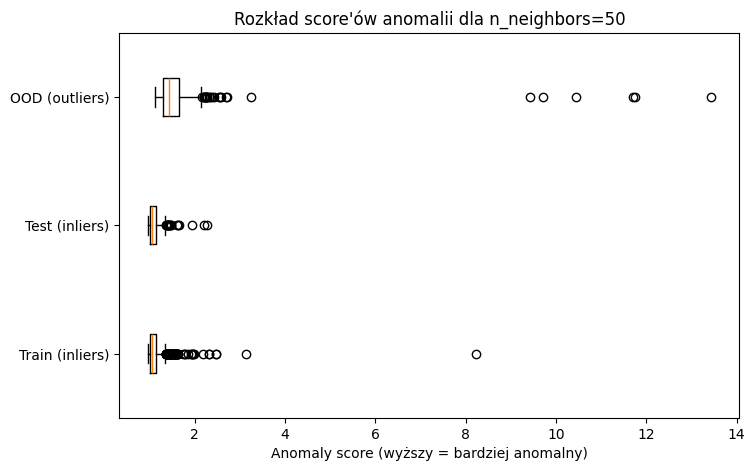

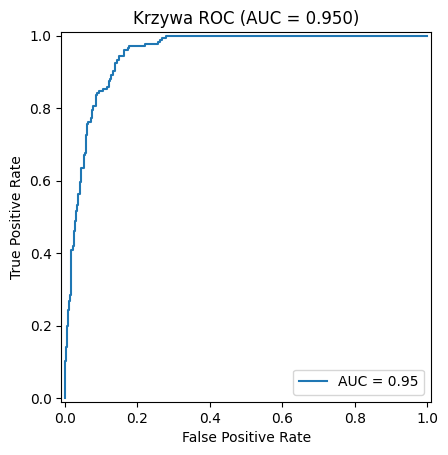


Najlepsze parametry: n_neighbors=50
AUC: 0.950
Optymalny próg: 1.017
TPR przy optymalnym progu: 0.960
FPR przy optymalnym progu: 0.163


In [5]:
# Wykres pudełkowy dla najlepszego modelu
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(
    [-best_train_scores, -best_test_scores, -best_ood_scores],  # Negujemy dla interpretacji "im wyższy = bardziej anomalny"
    labels=['Train (inliers)', 'Test (inliers)', 'OOD (outliers)'],
    vert=False
)
ax.set_title(f'Rozkład score\'ów anomalii dla n_neighbors={best_n}')
ax.set_xlabel('Anomaly score (wyższy = bardziej anomalny)')
plt.show()

# Krzywa ROC dla najlepszego modelu
combined_scores = np.concatenate([best_test_scores, best_ood_scores])
combined_labels = np.concatenate([np.zeros(len(best_test_scores)), np.ones(len(best_ood_scores))])
fpr, tpr, _ = roc_curve(combined_labels, -combined_scores)  # Używamy negowanych score'ów

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=best_auc).plot()
plt.title(f'Krzywa ROC (AUC = {best_auc:.3f})')
plt.show()

# Optymalny próg (Youden's J-statistic)
youden_idx = np.argmax(tpr - fpr)
optimal_threshold = -combined_scores[youden_idx]  # Ponieważ używaliśmy negowanych score'ów

print(f'\nNajlepsze parametry: n_neighbors={best_n}')
print(f'AUC: {best_auc:.3f}')
print(f'Optymalny próg: {optimal_threshold:.3f}')
print(f'TPR przy optymalnym progu: {tpr[youden_idx]:.3f}')
print(f'FPR przy optymalnym progu: {fpr[youden_idx]:.3f}')